# Build reference atlas from scratch

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarchest as sca
from scarchest.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download raw Dataset

In [4]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC
To: /home/marco/Documents/scarchesp/pbmc.h5ad
2.06GB [00:18, 112MB/s] 


'pbmc.h5ad'

In [10]:
adata = sc.read('pbmc.h5ad')

We now split the data into reference and query dataset to simulate the building process

In [11]:
target_conditions = ["10X"]
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 22779 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


For a better model performance it is necessary to filter the dataset first. We are doing this by applying the scanpy.pp function highly_variable_genes(). The 'n_top_genes' should be chosen in relation to the dataset size. The bigger the number of cells the bigger the number of genes can be selected.

In [12]:
sc.pp.highly_variable_genes(
    source_adata,
    layer="counts",
    n_top_genes=2000,
    batch_key="batch",
    subset=True,
)

For consistency we set adata.X to be raw counts. In other datasets that may be already the case

In [15]:
source_adata.X = source_adata.layers["counts"].copy()

## Create SCVI model and train it on reference dataset

In [17]:
sca.dataset.setup_anndata(source_adata, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 22779 cells, 2000 vars, 9 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [18]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  37%|███▋      | 183/500 [04:31<07:45,  1.47s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  37%|███▋      | 183/500 [04:32<07:52,  1.49s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  194 s. / 500 epochs                                                 


The resulting latent representation of the data can then be visualized with UMAP

In [22]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
reference_latent.obs["batch"] = source_adata.obs["batch"].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


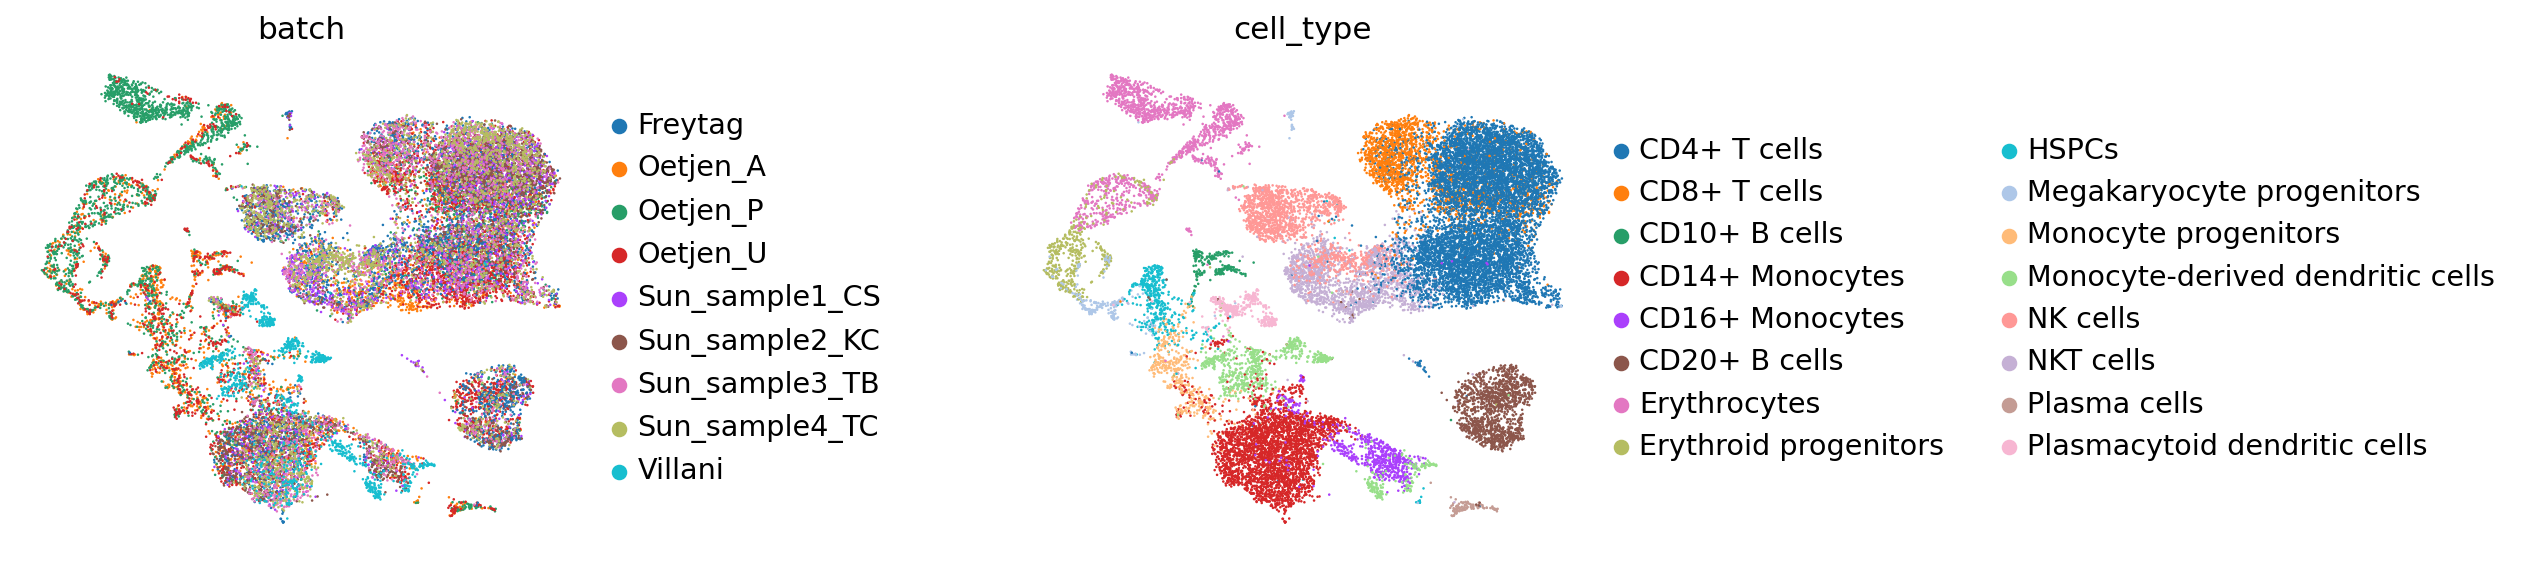

In [23]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use or also be uploaded for other researchers with via Zenodo. For the second option please also have a look at the Zenodo notebook.

In [24]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

### Use pretrained reference model and apply surgery with a new query dataset to get a bigger reference atlas

In [25]:
target_adata

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

Since the model requires the datasets to have the same genes we also filter the query dataset to have the same genes as the reference dataset. And also set adata.X to count values again.

In [27]:
target_adata = target_adata[:, source_adata.var_names].copy()
target_adata.X = target_adata.layers["counts"].copy()
target_adata

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

We then can apply the model surgery with the new query dataset:

In [28]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 10727 cells, 2000 vars, 10        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [30]:
model.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  11%|█▏        | 57/500 [00:37<04:30,  1.64it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  11%|█▏        | 57/500 [00:38<04:57,  1.49it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  24 s. / 500 epochs                                                  


In [32]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs["final_annotation"].tolist()
query_latent.obs['batch'] = target_adata.obs["batch"].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

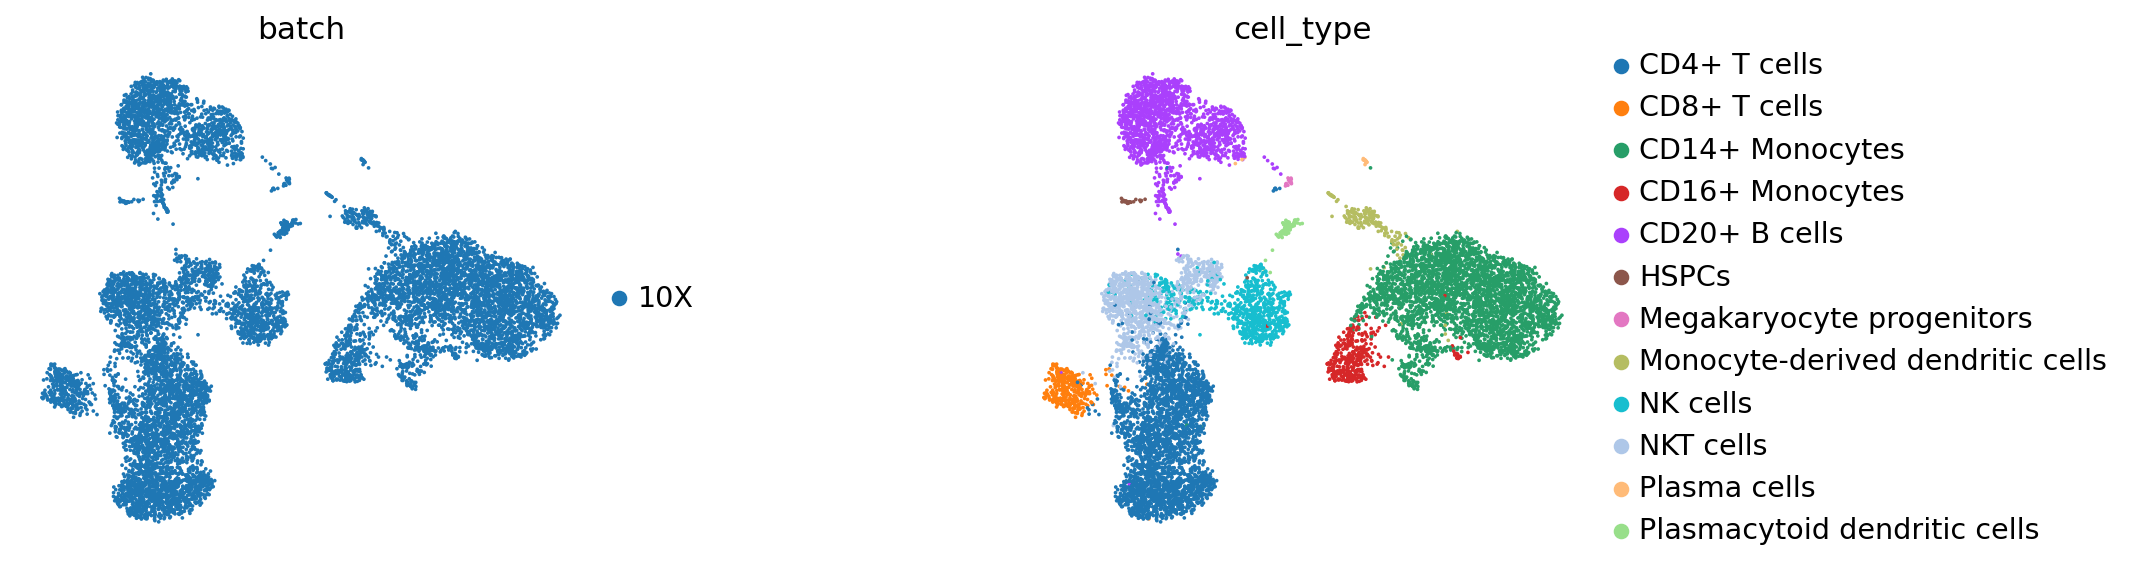

In [33]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

And again we can save or upload the retrained model for later use or additional extensions.

In [34]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

## Get latent representation of reference + query dataset and compute UMAP

In [40]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [41]:
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 33506 cells, 2000 vars, 10        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

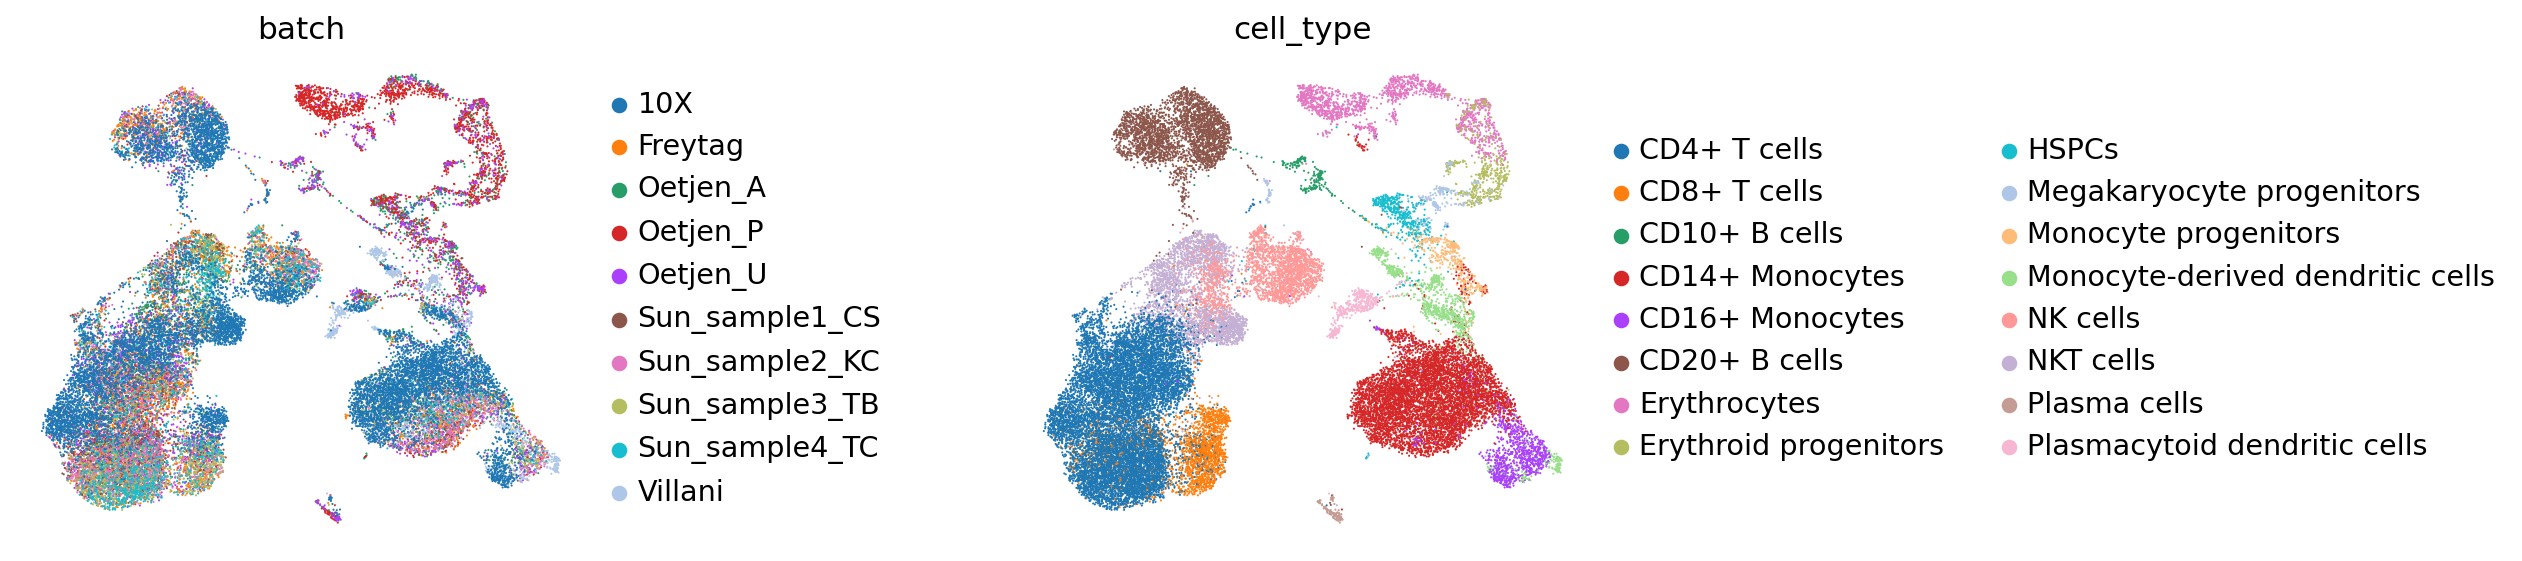

In [42]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)